In [2]:
import sys
sys.path.insert(-1, '..')

import puzzle.tester as tester
import puzzle.sudoku as su
from puzzle.jupyter_helpers import *
display(HTML(SUDOKU_CSS))

In [4]:
import copy
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 3)

In [5]:
import os.path
import datetime

TEST_RESULTS = "../data/sudoku_test_results.pkl"
NUM_SAMPLES = 5

pt = tester.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_test_cases([x for x in su.SAMPLE_PUZZLES])
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/hardest.txt", level="Hard"))
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/top95.txt", level="Diabolical"))
print(f"Using {pt.num_test_cases()} test cases")

if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
    print(f"Read previous test results from {TEST_RESULTS} from {datetime.datetime.fromtimestamp(os.path.getmtime(TEST_RESULTS))}")
    pt.set_test_results(df.to_dict('list'))

else:
    print(f"Generating {TEST_RESULTS} at {datetime.datetime.now()}...")
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)
    print(f"Saved {TEST_RESULTS} at {datetime.datetime.now()}")


Using 125 test cases
Read previous test results from ../data/sudoku_test_results.pkl from 2020-09-11 18:25:10.473189


---

# Diversions

Went down a few rabbit holes doing this...

## Diversion #1: Variability in performance on the *same* puzzle

Started looking at constrint propogation performance in more detail. The majority of the test puzzles are solved in < ~ 0.2 seconds, however there are some that take longer, up to a maxiumum of 12 seconds.

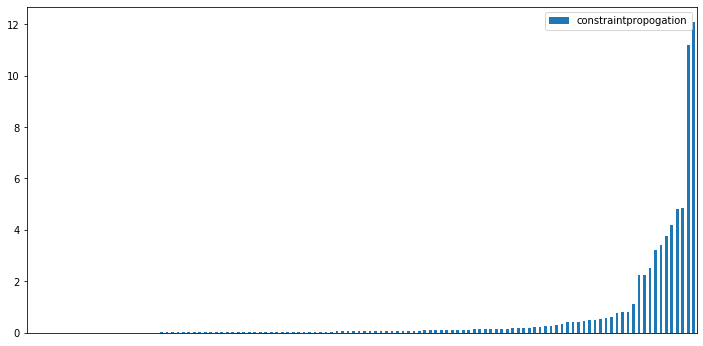

In [7]:
method = 'constraintpropogation'
axs = df.sort_values(by=method)[[method]].plot(kind='bar')
axs.xaxis.label.set_visible(False)
axs.xaxis.set_ticks([])
plt.show()

Let's take a look at those puzzles that take so much longer to solve and see if we can work out what's happening there.

In [8]:
def highlight_where_backtracking_faster(s):
    if s.constraintpropogation > s.backtracking:
        return ['background-color: yellow; color: black'] * len(s)
    else:
        return [''] * len(s)

method = 'constraintpropogation'
ndf = df.sort_values(by=method, ascending=False).head(n=15)
ndf.style.apply(highlight_where_backtracking_faster, axis=1).bar(subset=[method], color='orange').format({m: '{:.3f}' for m in su.SOLVERS})

,label,level,starting_clues,backtracking,constraintpropogation,deductive,sat
54,data/top95.txt:28,Diabolical,17,17.757,12.076,0.063,0.025
44,data/top95.txt:18,Diabolical,17,56.354,11.171,2.268,0.020
67,data/top95.txt:41,Diabolical,17,1173.908,4.840,3.015,0.021
33,data/top95.txt:7,Diabolical,17,1.697,4.804,1.025,0.026
47,data/top95.txt:21,Diabolical,17,43.075,4.180,2.395,0.020
34,data/top95.txt:8,Diabolical,17,113.328,3.775,4.442,0.022
36,data/top95.txt:10,Diabolical,17,108.590,3.400,5.219,0.019
35,data/top95.txt:9,Diabolical,17,1.691,3.226,0.491,0.036
97,data/top95.txt:71,Diabolical,17,205.605,2.515,2.329,0.019
31,data/top95.txt:5,Diabolical,17,790.428,2.263,1.707,0.021


Interesting points:

* Puzzles 7 and 9 (highlighted yellow) actually take longer to solve with the constraint propogation solution than simple backtracking
* Puzzles 21 and 46 look like good candidates for looking at closer, because the backtracking time isn't so long that we can't wait for profiler output if we want to compare profiles
* Puzzle 42 looks like a good place to start though: < ~1 second (highlighted green), deductive method on the same puzzle *much* faster, and backtracking time not so long tha we can't wait.

### Puzzle 42

So started looking at Puzzle 42 (answer to the Ultimate Question?), using the built in Jupyet profiler tools. First though, a quick check that the total time matches up. According to original testing performance, this should take ~8 microseconds (ms).


In [9]:
puzzle42 = '......8.16..2........7.5......6...2..1....3...8.......2......7..3..8....5...4....'
puzzle = su.SudokuPuzzle()
puzzle.init_puzzle(su.from_string(puzzle42))
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 793 ms, sys: 8.39 ms, total: 801 ms
Wall time: 837 ms


True

That looks OK. So reset the puzzle and profile below. The profiler itself adds some overhead so this takes slightly longer (~1.2 seconds).

In [10]:
puzzle.init_puzzle(su.from_string(puzzle42))
s = su.SudokuSolver(method=method)
%prun s.solve(puzzle)

         2030331 function calls (2001341 primitive calls) in 1.164 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   398932    0.363    0.000    0.654    0.000 sudoku.py:181(get_allowed_values)
    57980    0.246    0.000    0.837    0.000 latinsquare.py:302(next_best_empty_cell)
   398932    0.194    0.000    0.194    0.000 latinsquare.py:326(get_allowed_values)
   456848    0.112    0.000    0.112    0.000 sudoku.py:131(box_xy_to_num)
  28991/1    0.074    0.000    1.164    1.164 sudoku.py:340(_solve_backtracking)
    28990    0.039    0.000    0.088    0.000 latinsquare.py:213(set)
    28926    0.031    0.000    0.072    0.000 sudoku.py:156(clear)
    28990    0.029    0.000    0.127    0.000 sudoku.py:143(set)
    28926    0.025    0.000    0.031    0.000 latinsquare.py:250(clear)
   341006    0.022    0.000    0.022    0.000 {built-in method builtins.len}
    86970    0.009    0.000    0.009    0.000 {method 'remove' 

Notes:

* 399K calls to `get_allowed_values`. The first entry is in [sudoku.py](sudoku.py#line_88), which gets the allowed values for the box, then calls the same method in the [parent class](puzzlegrid.py#line_321) to return the intersection of allowed cells in that row, column and box.
* Recurses into `solve_constraintpropogation` 29K times.

Compare the performance of #42 to #46. Expect #46 to take ~2.5 seconds.

In [11]:
puzzle46 = '.834.........7..5...........4.1.8..........27...3.....2.6.5....5.....8........1..'
puzzle.init_puzzle(su.from_string(puzzle46))
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 249 ms, sys: 4.54 ms, total: 253 ms
Wall time: 260 ms


True

OK, this is weird. That was supposed to take ~2.5 seconds and instead finished in ~0.3 seconds. Let's run it again...and again. And this time we'll output some of the stats collected by the solver itself:

* Max Depth: The deepest stack-depth the recursion reached
* Backtracks: The number of "mistakes" made by the algorithm that resulted in it backtracking to a prior state


In [12]:
method

'constraintpropogation'

In [13]:
puzzle = su.SudokuPuzzle()
solver = su.SudokuSolver(method=method)
for i in range(5):
    print(f"RUN {i}")
    puzzle.init_puzzle(starting_grid=su.from_string(puzzle46))
    assert(not puzzle.is_solved())
    %time solver.solve(puzzle)
    print(f"Max Depth={solver.solver.max_depth}; Backtracks={solver.solver.backtrack_count}\n")

RUN 0
CPU times: user 2.68 s, sys: 26.3 ms, total: 2.7 s
Wall time: 2.76 s
Max Depth=63; Backtracks=105917

RUN 1
CPU times: user 2.55 s, sys: 10.7 ms, total: 2.57 s
Wall time: 2.6 s
Max Depth=63; Backtracks=105917

RUN 2
CPU times: user 224 ms, sys: 1.09 ms, total: 225 ms
Wall time: 226 ms
Max Depth=63; Backtracks=8766

RUN 3
CPU times: user 228 ms, sys: 1.41 ms, total: 230 ms
Wall time: 231 ms
Max Depth=63; Backtracks=8766

RUN 4
CPU times: user 245 ms, sys: 2.43 ms, total: 247 ms
Wall time: 251 ms
Max Depth=63; Backtracks=8766



In testing, the first two usually take ~2.5 seconds, and the last 3 take ~220 ms. Even though it's exactly the same puzzle being solved by exactly the same algorithm.

It turns out the difference is caused by the return order of the set of allowed values. Since the values are returned in a set, the order of the elements is not guaranteed to be consistent. When the order is slightly different, then the backtracking can take dramatically different search paths, with consequent impacts on run time. You can see this in the `Backtracks` reported (~106K vs ~9K).

In this specific case, one of the cells has allowed values (1, 9). If "1" is chosen then the solution takes 2.5 seconds to find. However if the "9" is chosen, then the search takes ~220 ms. 

If I modify the algorithm to always sort the allowed values then the performance time is always consistent. Otherwise there's a certain amount of randmomness to it.

The other change is to recreate the `puzzle` instance each time. When I do that, the performance remains consistent, because the set order remains consistent. Not sure why that is.
